In [9]:
%%shell
#pip installs
pip install cython
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-ixo6li2r
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-ixo6li2r
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=263920 sha256=cadb41e9a08ddb8a346b4ddd305c0ab57943ccf9cd759781e27de43ef9668729
  Stored in directory: /tmp/pip-ephem-wheel-cache-7w3_gtg0/wheels/90/51/41/646daf401c3bc408ff10de34ec76587a9b3ebfac8d21ca5c3a
Successfully built pycocotools
  Found existing installation: pycocotools 2.0
    Uninstalling pycocotools-2.0:
      Successfully uninstalled pycocotools-2.0
fatal: destination path 'vision' already exists and is not an empty directory.
HEAD is now at be376084 version check against PyTorch's CUDA version


In [10]:
#imports

import numpy as np
import pandas as pd
import os
import pycocotools
import torchvision
import torch
from PIL import Image
import matplotlib.pyplot as plt


In [11]:
#Folder Setup: SL_combined.csv and Sign_Images.zip in content, model in folder "Model", predictions folder empty

In [ ]:
if not os.path.isdir('Sign_Images'):
  !unzip -o Sign_Images.zip

In [13]:
dataset = pd.read_csv("SL_combined.csv")
filenames = dataset.filename.unique()

print(dataset)

    stroke   x1   y1   x2   y2  filename  wfile  hfile
0    Wedge   80  255  410  256   1.0.png    500    500
1    Wedge  176  178  405  380   2.0.png    500    500
2    Wedge  153  346  420  143   2.0.png    500    500
3    Wedge   49  258  468  257   2.0.png    500    500
4     Line   91  101   86  372   3.0.png    500    500
..     ...  ...  ...  ...  ...       ...    ...    ...
791  Wedge   14   70   91   68  58.0.png    240    172
792  Wedge  115   22   92  116  58.0.png    240    172
793  Wedge  142   67  138  123  58.0.png    240    172
794  Wedge  171   21  180  124  58.0.png    240    172
795  Wedge   53  133  212  127  58.0.png    240    172

[796 rows x 8 columns]


In [14]:
def strokenum(s):
  '''
  Converts string labels to integer:
  1 = Wedge, 2 = Winkelhaken, 3 = Line

  input: s (string, sign label)
  '''
  if s == "Wedge":
    return 1
  elif s == "Winkel":
    return 2
  elif s == "Line":
    return 3
  else: raise Exception("Error: Invalid Stroke")

def linestack(x1,x2,y1,y2, w, h):
  '''
  Draws a bbox around keypoints, with a 20px-ish buffer
  '''
  xmin = np.maximum(0, np.minimum(x1,x2) - 20)
  ymin = np.maximum(0, np.minimum(y1,y2) - 20)
  xmax = np.minimum(w, np.maximum(x1,x2) + 20)
  ymax = np.minimum(h, np.maximum(y1,y2) + 20)
  return np.stack([xmin,ymin,xmax,ymax], axis=1)

class SLDataset(object):
  def __init__(self, imgdir, labelset, transforms = None):
    self.transforms = transforms
    self.imgdir = imgdir
    self.imgs = list(sorted(os.listdir(imgdir)))#[1:]
    self.labelset = labelset

    #print(self.imgs)

  def __getitem__(self, idx):
    img_path = os.path.join(self.imgdir, self.imgs[idx])
    img = Image.open(img_path).convert("RGB")
    
    filter = self.labelset['filename'] == self.imgs[idx]
    labelsubset = self.labelset[filter]
    #print(len(labelsubset))

    name = self.imgs[idx].strip(".png")

    x1 = labelsubset.x1.to_numpy()
    y1 = labelsubset.y1.to_numpy()
    x2 = labelsubset.x2.to_numpy()
    y2 = labelsubset.y2.to_numpy()
    num_strokes = len(x1)

    imgh = labelsubset.hfile.to_numpy()
    imgw = labelsubset.wfile.to_numpy()

    boxes = linestack(x1=x1,x2=x2,y1=y1,y2=y2, w = imgw, h = imgh)
    # boxes = np.transpose(np.array([np.zeros(num_strokes), 
                                  #  np.zeros(num_strokes), 
                                  #  imgh, 
                                  #  imgw]))
    boxes = torch.as_tensor(boxes, dtype=torch.float32)


    pt1 = np.stack([x1,y1, np.ones_like(x1)], axis=1)
    pt2 = np.stack([x2,y2, np.ones_like(x1)], axis=1)
    fillers = np.zeros([num_strokes, 15, 3])
    kp = np.stack([pt1,pt2], axis=1)
    keypoints = np.pad(kp, [[0,0],[0,15],[0,0]])
    keypoints = torch.as_tensor(keypoints, dtype = torch.float32)

    area = torch.as_tensor(np.abs((x2-x1)*(y2-y1)), dtype=torch.float32)

    labels = labelsubset.stroke.to_numpy()
    labels = np.array([strokenum(s) for s in labels])
    # labels = np.ones(num_strokes)
    labels = torch.as_tensor(labels, dtype=torch.int64)

    image_id = torch.tensor([idx])
    iscrowd = torch.zeros(num_strokes, dtype=torch.int64)


    target = {}
    target["boxes"] = boxes
    target["keypoints"] = keypoints
    target["labels"] = labels
    target["image_id"] = image_id
    target["iscrowd"] = iscrowd
    target["area"] = area
    target["name"] = name

    #print(boxes)
    
    if self.transforms is not None:
      img, target = self.transforms(img, target)

    return img, target

  def __len__(self):
    return len(self.imgs)

In [15]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T

def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    # if train:
    #     transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

torch.Size([4, 17, 3])
torch.Size([4, 4])


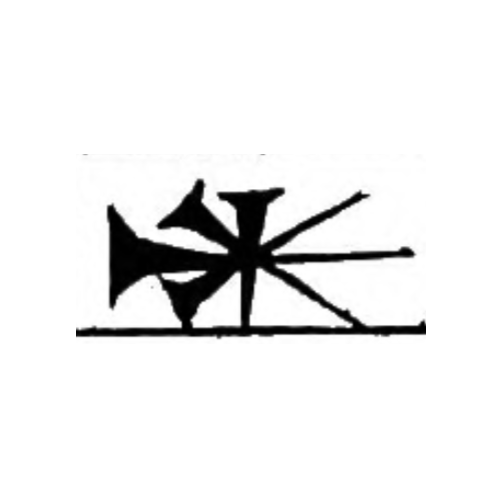

In [16]:
data = SLDataset(imgdir="/content/Sign_Images", labelset=dataset, transforms=get_transform(train=False))

sampleimg = data.__getitem__(2)

print((sampleimg[1]["keypoints"]).shape)
print((sampleimg[1]["boxes"]).shape)

#print(f'Sample Keypoint Shape: {sampleimg[1]["keypoints"].shape}')
Image.fromarray(sampleimg[0].mul(255).permute(1, 2, 0).byte().numpy())

In [18]:
model = torchvision.models.detection.keypointrcnn_resnet50_fpn(pretrained=False,
                                                               num_classes = 4,)

model.load_state_dict(torch.load('Model/model_20210504_0924', map_location=torch.device('cpu'))) #replace with model file name
model.eval()


KeypointRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(640, 672, 704, 736, 768, 800), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, 

In [19]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)


KeypointRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(640, 672, 704, 736, 768, 800), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, 

In [20]:
def run_strokeseg(input, labeled = True):
  output = []

  for n in range(len(input)):
    img, target = input[n]
    dim = np.shape(img)

    with torch.no_grad():
      prediction = model([img.to(device)])[0]
    
    scores = prediction["scores"].cpu().numpy()
    keypoints = prediction["keypoints"].cpu().numpy()
    labels = prediction["labels"].cpu().numpy()

    name = target["name"]

    if labeled:
      gtkeypoints = target["keypoints"][:,:2]
      gtlabels = target["labels"]

    if labeled:
      pred = {'name': name,
              'dim': dim,
              'scores': scores,
              'keypoints': keypoints,
              'labels': labels,
              'gtkeypoints': gtkeypoints,
              'gtlabels': gtlabels}
    else:
      pred = {'name': name,
              'dim': dim,
              'scores': scores,
              'keypoints': keypoints,
              'labels': labels}

    output.append(pred)

  return output

In [ ]:
predictions = run_strokeseg(data)
print(len(predictions))

In [ ]:
#save predictions for next step:
import pickle
import datetime as dt

now = dt.datetime.now().strftime("%Y%m%d_%H%M")
print(now)

with open(f"predictions/stroke_predictions_{now}.txt", "wb") as fp:
  pickle.dump(predictions, fp)

In [ ]:
from PIL import ImageDraw

def boxsample(n, source = data, predictions = predictions, thr = 0.95, show = False):
  img, _ = source[n]
  pred = predictions[n]

  image = Image.fromarray(img.mul(255).permute(1, 2,0).byte().numpy())
  draw = ImageDraw.Draw(image)
  
  num_strokes = len(pred["scores"])
  points = pred['keypoints']
  scores = pred['scores']


  for element in range(num_strokes):
    point = points[element][:2,:2]
    score = scores[element]

    #print(point)
    
    if score > thr:
        draw.text(point[0], text = str(element), fill = 'blue', )
        draw.text(point[1], text = str(element), fill = 'green', )

  if show:
    plt.imshow(image)
    plt.axis('off')
    plt.show()

  return image, prediction

im, pred = boxsample(-1, data, thr = 0.5, show = False)

im

In [49]:
# class Evaldataset(object):
#   def __init__(self, imgdir, transforms = None):
#     self.transforms = transforms
#     self.imgdir = imgdir
#     self.imgs = list(sorted(os.listdir(imgdir)))[1:]
#     #print(self.imgs)

#   def __getitem__(self, idx):
#     img_path = os.path.join(self.imgdir, self.imgs[idx])
#     img = Image.open(img_path).convert("RGB")
#     target = {}
#     target['name'] = self.imgs[idx]
    
#     if self.transforms is not None:
#       img, _ = self.transforms(img, target)

#     return img, target

#   def __len__(self):
#     return len(self.imgs)

In [50]:
# Evals = Evaldataset(imgdir = 'Eval_Images', transforms=get_transform(train=False))


In [51]:
# def run_strokeseg_eval(input, labeled = True):
#   output = []

#   for n in range(len(input)):
#     img, target = input[n]
#     dim = np.shape(img)

#     with torch.no_grad():
#       prediction = model([img.to(device)])[0]
    
#     scores = prediction["scores"].cpu().numpy()
#     keypoints = prediction["keypoints"].cpu().numpy()
#     labels = prediction["labels"].cpu().numpy()

#     name = target["name"]

#     pred = {'name': name,
#               'dim': dim,
#               'scores': scores,
#               'keypoints': keypoints,
#               'labels': labels}

#     output.append(pred)

#   return output

In [29]:
# if not os.path.isdir('Eval_Images'):
#   !unzip -o Eval_Images.zip

In [52]:
# evalpreds = run_strokeseg_eval(input = Evals)

In [54]:
# #save predictions for next step:
# import pickle

# with open(f"predictions/eval_predictions", "wb") as fp:
#   pickle.dump(evalpreds, fp)